In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import albumentations as A
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam

In [2]:
tfms = A.Compose([A.Resize(28,28)])

In [3]:
class XODataset(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.files = os.listdir(folder)
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        f = self.files[ix]
        img = cv.imread(os.path.join(self.folder, f))[:, :, 0]
        img = tfms(image=img)["image"]
        img = img[np.newaxis, ...]
        label = f.split("@")[0] == "x"
        img = torch.tensor(1-img/255., dtype=torch.float)
        label = torch.tensor([label], dtype=torch.float)
        return img, label

In [4]:
xo_data = XODataset("data/all")
img, label= xo_data.__getitem__(0)
img.shape, label

(torch.Size([1, 28, 28]), tensor([1.]))

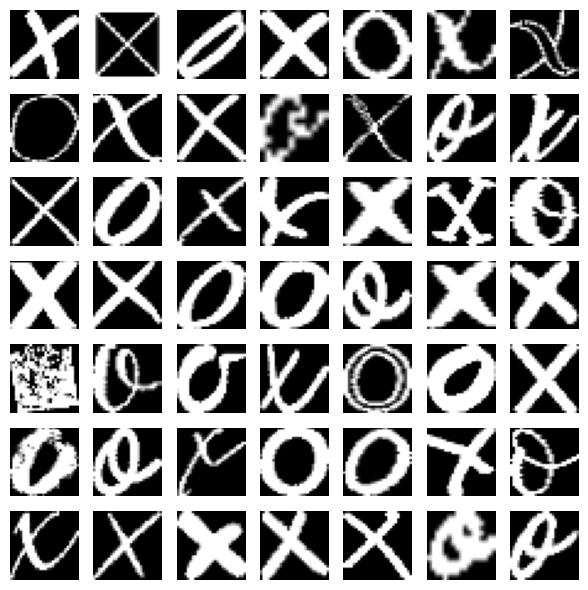

In [5]:
# show images
R, C = 7, 7
fig, ax = plt.subplots(R, C, figsize=(6, 6), dpi=100)
for label_cls, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid('off')
        plot_cell.axis('off')
        ix = np.random.choice(1000)
        img, label = xo_data[ix]
        plot_cell.imshow(img[0], cmap="gray")
fig.tight_layout()
plt.show()

In [6]:
class XONet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3200, 256)
        self.fc2 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = F.relu(x)
        x = self.pool2(self.conv2(x))
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XONet()
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
model = model.to(device)

In [8]:
from torchinfo import summary
summary(model, input_size = (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
XONet                                    [1, 1]                    --
├─Conv2d: 1-1                            [1, 64, 26, 26]           640
├─MaxPool2d: 1-2                         [1, 64, 13, 13]           --
├─Conv2d: 1-3                            [1, 128, 11, 11]          73,856
├─MaxPool2d: 1-4                         [1, 128, 5, 5]            --
├─Linear: 1-5                            [1, 256]                  819,456
├─Linear: 1-6                            [1, 1]                    257
Total params: 894,209
Trainable params: 894,209
Non-trainable params: 0
Total mult-adds (M): 10.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.47
Params size (MB): 3.58
Estimated Total Size (MB): 4.05

In [9]:
def train_batch(x, y, model, opt, loss_fn):
    opt.zero_grad()
    model.train()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    return batch_loss.item(), is_correct[0]

In [10]:
train_loader = DataLoader(xo_data, batch_size=32, drop_last=True)

In [11]:
epoch_losses = []
for epoch in range(5):
    batch_losses = []
    for batch in train_loader:
        x, y  = batch
        x = x.to(device)
        y = y.to(device)
        out = train_batch(x, y, model, optimizer, criterion)
        batch_losses.append(out[0])
    epoch_losses.append(np.mean(batch_losses))

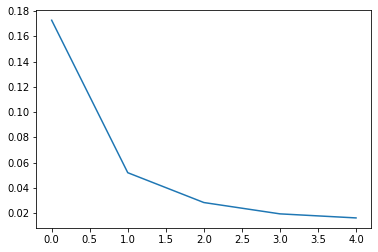

In [12]:
plt.plot(epoch_losses)
plt.show()

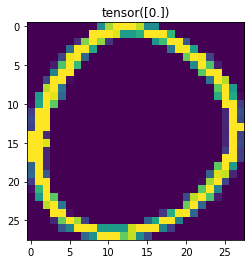

In [13]:
image, label = train_loader.dataset[15]
plt.imshow(image[0])
plt.title(label)
plt.show()

In [14]:
# extract layers from the network
first_layer = nn.Sequential(dict(model.named_children())["conv1"])
intermediate_output = first_layer(image[None].to(device)).cpu().detach()

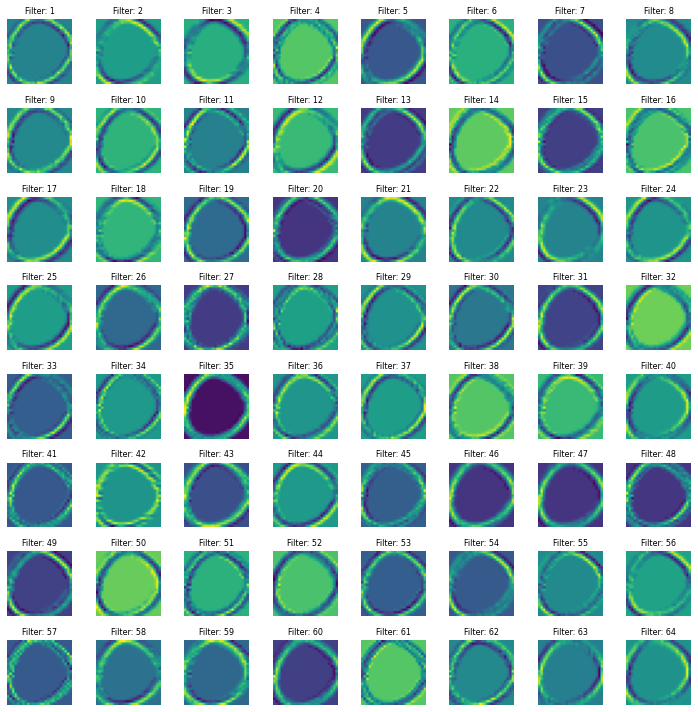

In [15]:
# plot the 64 filters from the intermediate output
fig, ax = plt.subplots(8, 8, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    axis.set_title(f'Filter: {ix+1}', fontsize=8)
    axis.axis('off')
    axis.imshow(intermediate_output[0][ix])
fig.tight_layout()
plt.show()

In [18]:
first_batch = next(iter(train_loader))
batch_images = first_batch[0]
intermediate_first_batch_output = first_layer(batch_images.to(device)).cpu().detach()

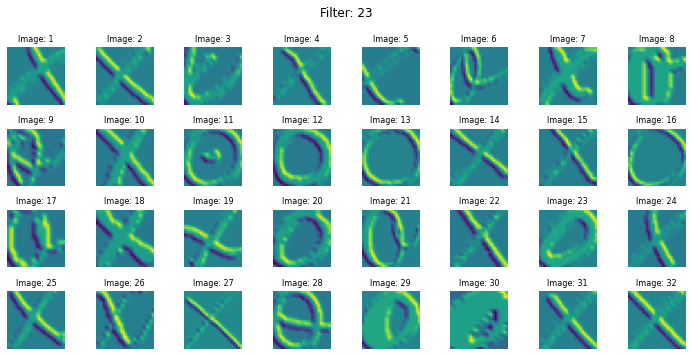

In [22]:
# plot the output of 23rd filter for all the images in a batch
fig, ax = plt.subplots(4, 8, figsize=(10, 5))
fig.suptitle("Filter: 23", fontsize=12)
for ix, axis in enumerate(ax.flat):
    axis.set_title(f'Image: {ix+1}', fontsize=8)
    axis.axis('off')
    axis.imshow(intermediate_first_batch_output[ix][22])
fig.tight_layout()
plt.show()

In [27]:
# extract layers from the network
second_layer = nn.Sequential(*list(model.children())[:3])
second_intermediate_output = second_layer(image[None].to(device)).cpu().detach()

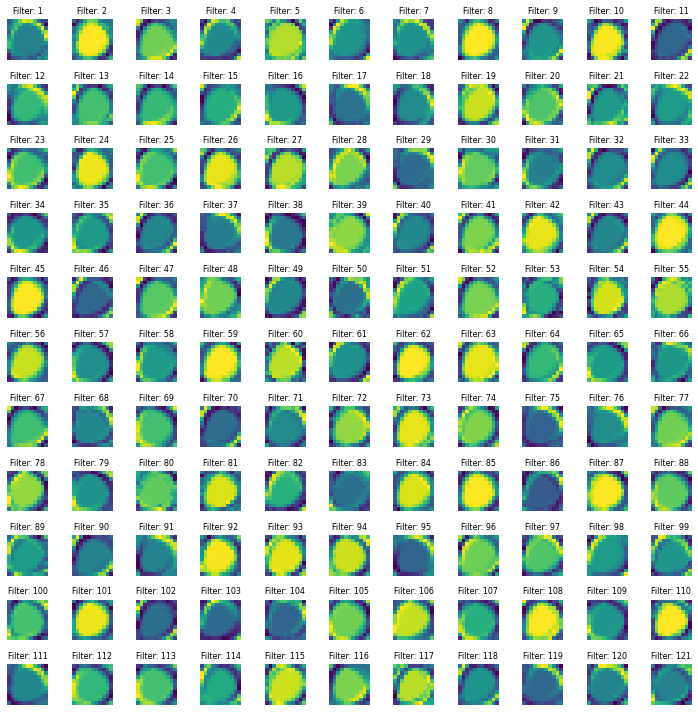

In [28]:
# plot the 128 filters from the intermediate output
fig, ax = plt.subplots(11, 11, figsize=(10, 10))
for ix, axis in enumerate(ax.flat):
    axis.set_title(f'Filter: {ix+1}', fontsize=8)
    axis.axis('off')
    axis.imshow(second_intermediate_output[0][ix])
fig.tight_layout()
plt.show()

In [26]:
list(model.children())

[Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Linear(in_features=3200, out_features=256, bias=True),
 Linear(in_features=256, out_features=1, bias=True)]